# Multi armed bandit

*Multi-armed bandit* is a problem of choosing between alternative options with unknown rewards, trying to maximize your expected reward and to learn it at the same time. A [wiki article](https://en.wikipedia.org/wiki/Multi-armed_bandit), a [good blogpost](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html) about it. 

In this notebook, we'll create a simple environment for simulating such problems and try a couple of strategies dealing with them.

### Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This class will generate rewards for each action taken by the solver. 

In [3]:
class BinaryEnvironment:
    def __init__(self, actions, rewards=None):
        self.actions = actions
        if rewards is None:
            rewards = np.linspace(0.05, 0.95, len(self.actions))
        self.success_proba = dict(zip(self.actions, rewards))
    def generate_reward(self, action):
        return int(np.random.uniform() < self.success_proba[action])

This is the base class for different problem solvers.

In [4]:
class BaseBandit:
    def __init__(self, actions):
        self.actions = actions
    def reset(self):
        pass 
    def choose_next_action(self):
        raise NotImplementedError()
    def update(self, action, reward):
        raise NotImplementedError()

Now we can write a fuction that puts our solver into the environment and looks how well it works. 

In [5]:
def simulate(env, solver, n_sims=100, n_steps=100):
    mean_rewards = []
    mean_curve = np.zeros(shape=n_steps)
    for sim in range(n_sims):
        solver.reset()
        actions = []
        rewards = []
        for i in range(n_steps):
            a = solver.choose_next_action()
            r = env.generate_reward(a)
            actions.append(a)
            rewards.append(r)
            solver.update(a, r)
        mean_rewards.append(np.mean(rewards))
        mean_curve += np.cumsum(rewards) / n_sims
    plt.plot(mean_curve / np.arange(1, n_steps+1))
    plt.xlabel('time')
    plt.ylabel('mean cumulative reward')
    #print(np.mean(mean_rewards))
    return np.mean(mean_rewards)

Let's try a simple solver that just chooses an action at random

In [6]:
class RandomBandit(BaseBandit):
    def choose_next_action(self):
        return np.random.choice(self.actions)
    def update(self, action, reward):
        pass

In [7]:
options = np.arange(10)
env = BinaryEnvironment(options)

For a random bandit, mean reward as a function of time is just a random walk: it doesn't use previous experience at all. 

0.5059

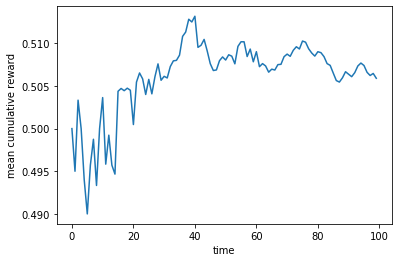

In [8]:
bandit = RandomBandit(actions=options)
simulate(env, bandit)

## epsilon-greedy

Instead of pure randomness, we can code a so-called `epsilon-greedy` solver: with probability $\varepsilon$ it explores (takes a random uniform action), and with probability $1-\varepsilon$ it exploits: chooses the action with the best mean reward, according to its history. 

In [9]:
from collections import Counter

def dict_argmax(data):
    max_value = -np.inf
    argmax = None
    for key, value in data.items():
        if value > max_value:
            max_value = value
            argmax = key
    return argmax

class EpsilonGreedyBandit(BaseBandit):
    def __init__(self, actions, epsilon=0.1):
        super(EpsilonGreedyBandit, self).__init__(actions)
        self.epsilon = epsilon
    def reset(self):
        self.action_counts = Counter()
        self.action_sums = Counter()
        self.update_means()
    def update_means(self):
        self.means = {a: total / self.action_counts[a] for a, total in self.action_sums.items()}
    def choose_next_action(self):
        if not self.means or np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return dict_argmax(self.means)
    def update(self, action, reward):
        self.action_counts[action] +=1
        self.action_sums[action] += reward
        self.update_means()

Now we can look at how different values of $\varepsilon$ perform.

You can see that when $\varepsilon$ is too high, the mean reward converges to a smaller value, because the proportion of random actions is high. 

And if $\varepsilon$ is too low, the solver sticks to a suboptimal action too early, and improves very slowly. 

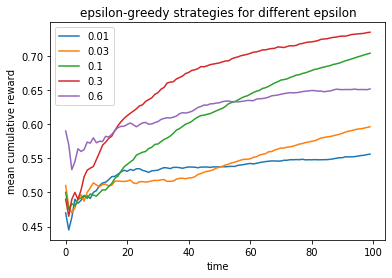

In [10]:
epsilons = [0.01, 0.03, 0.1, 0.3, 0.6]
for eps in epsilons:
    bandit = EpsilonGreedyBandit(actions=options, epsilon=eps)
    simulate(env, bandit)
plt.legend(epsilons)
plt.title('epsilon-greedy strategies for different epsilon');

## UCB bandit

We can improve our solver even further, by making it choose on each step the action with the highest possible upper confidence bound for mean reward.

One of simple ways to approximate upper confidence bound for mean is to add several standard deviations of tne sample mean to the sample mean - like in normal distribution (to which distribution of sample mean will sooner or later converge):

$$ UCB = \bar{x} + m\frac{\hat{\sigma}}{\sqrt{n}}$$

Here $m$ is just some multiplier that reflects the degree of exploration we are going to do. The higher is this multiplier, the more will be the tendency to try actions with small $n$ and high $\hat{\sigma}$  - that is, the most uncertain actions.


In [11]:
class UpperConfidenceBandit(BaseBandit):
    def __init__(self, actions, multiplier):
        super(UpperConfidenceBandit, self).__init__(actions)
        self.multiplier = multiplier
    def reset(self):
        # we initialize the counters with one imaginary success and one imaginary failure
        # it's just a heuristic, nothing scientific about it
        self.action_counts = {action: 2 for action in self.actions}
        self.action_sums = {action: 1 for action in self.actions}
        self.update_ucbs()
    def update_ucbs(self):
        self.means = {a: self.action_sums[a] / self.action_counts[a] for a in self.actions}
        # todo: calculate ucbs as a dict of upper confidence bounds, according to the formula above
        self.ucbs = {
            action: (mean + 
                     self.multiplier * ((np.sqrt(mean * (1 - mean))) / np.sqrt(self.action_counts[action])))
            for action, mean in self.means.items()
        }
    def choose_next_action(self):
        return dict_argmax(self.ucbs)
    def update(self, action, reward):
        self.action_counts[action] += 1
        self.action_sums[action] += reward
        self.update_ucbs()

Now we can try how our strategy works with different multipliers. 

It seems that a very small multiplier is already enough to explore all the options well enough and quickly converge to the best one. 

0.8347999999999999


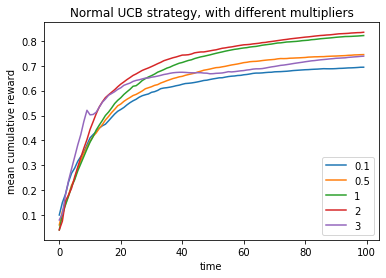

In [12]:
multipliers = [0.1, 0.5, 1, 2, 3]
mean_returns = []
for mul in multipliers:
    ucbb = UpperConfidenceBandit(actions=options, multiplier=mul)
    mean_returns.append(simulate(env, ucbb))
plt.legend(multipliers);
plt.title('Normal UCB strategy, with different multipliers');

print(max(mean_returns))
assert max(mean_returns) > 0.8

### The assignment: other strategies

Our environment is constructed in such a way, that maximum possible average reward is 0.95 (if the solver knew the best action from the very beginning). 

Of course, no real algorithm can achieve this mean reward, but some algorithms can come close to it. 

In the last part of the notebook, try to create a solver that works even better than the normal UCB algorithm above. 

One of the ideas you can explore is changing the parameters over time, e.g. gradually decreasing $\varepsilon$ or $m$, so that the algorithm starts with aggressive exploration and then faster switches to exploitation. 


In [23]:
class MyBandit(BaseBandit):
    def __init__(self, actions, multiplier):
        super(MyBandit, self).__init__(actions)
        self.multiplier = multiplier
    def reset(self):
        # we initialize the counters with one imaginary success and one imaginary failure
        # it's just a heuristic, nothing scientific about it
        self.action_counts = {action: 2 for action in self.actions}
        self.action_sums = {action: 1 for action in self.actions}
        self.update_ucbs()
    def update_ucbs(self):
        self.means = {a: self.action_sums[a] / self.action_counts[a] for a in self.actions}
        total_pulls_of_all_actions = sum([self.action_counts[a] for a in self.actions])
        self.ucbs = {
            action: (mean + 
                     self.multiplier * np.sqrt(np.log(2 * total_pulls_of_all_actions) / self.action_counts[action]))
            for action, mean in self.means.items()
        }
        self.multiplier -= 0.00000001
        
    def choose_next_action(self):
        return dict_argmax(self.ucbs)
    def update(self, action, reward):
        self.action_counts[action] += 1
        self.action_sums[action] += reward
        self.update_ucbs()

0.931215


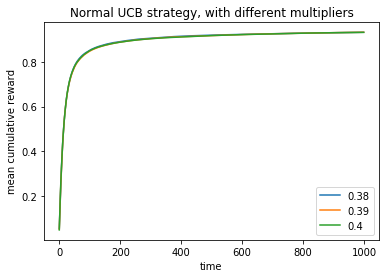

In [25]:
multipliers = [0.38, 0.39, 0.4]
mean_returns = []
for mul in multipliers:
    ucbb = MyBandit(actions=options, multiplier=mul)
    mean_returns.append(simulate(env, ucbb, n_sims=1000, n_steps=1000))
plt.legend(multipliers);
plt.title('Normal UCB strategy, with different multipliers');

print(max(mean_returns))
assert max(mean_returns) > 0.8